<a href="https://colab.research.google.com/github/sairamkiran9/Face-Recognition-/blob/master/Pattern_Face_recg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [ ]:
def normalize(X, low, high, dtype=None):
    X = np.asarray(X)
    minX, maxX = np.min(X), np.max(X)
    X = X - float(minX)
    X = X / float((maxX - minX))
    X = X * (high-low)
    X = X + low
    if dtype is None:
        return np.asarray(X)
    return np.asarray(X, dtype=dtype)

def asRowMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((0, X[0].size), dtype=X[0].dtype)
    for row in X:
        mat = np.vstack((mat, np.asarray(row).reshape(1,-1)))
    return mat

def asColumnMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((X[0].size, 0), dtype=X[0].dtype)
    for col in X:
        mat = np.hstack((mat, np.asarray(col).reshape(-1,1)))
    return mat

In [ ]:
def class_encode(labels):
    label_encoder = preprocessing.LabelEncoder()  
    labels = label_encoder.fit_transform(labels) 
    return labels 

def project(W, X, mu=None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X - mu, W)

def dist_metric(p, q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    return np.sqrt(np.sum(np.power((p-q),2)))

def pca(X, y, num_components,wo = 0):
    [n,d] = X.shape
    if (num_components <= 0) or (num_components>n):
        num_components = n
    mu = X.mean(axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    eigenvalues = eigenvalues[wo:num_components+wo].copy()
    eigenvectors = eigenvectors[:,wo:num_components+wo].copy()
    return [eigenvalues, eigenvectors, mu]

def lda(X, y, num_components):
    y = np.asarray(y)
    [n,d] = X.shape
    c = np.unique(y)
    if (num_components <= 0) or (num_components>(len(c))):
        num_components = (len(c)-1)
    meanTotal = X.mean(axis=0)
    Sw = np.zeros((d, d), dtype=np.float32)
    Sb = np.zeros((d, d), dtype=np.float32)
    for i in c:
        Xi = X[np.where(y==i)[0],:]
        meanClass = Xi.mean(axis=0)
        Sw = Sw + np.dot((Xi-meanClass).T, (Xi-meanClass))
        Sb = Sb + n * np.dot((meanClass - meanTotal).T, (meanClass - meanTotal))
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw)*Sb)
    idx = np.argsort(-eigenvalues.real)
    eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:,idx]
    eigenvalues = np.array(eigenvalues[0:num_components].real, dtype=np.float32, copy=True)
    eigenvectors = np.array(eigenvectors[0:,0:num_components].real, dtype=np.float32, copy=True)
    return [eigenvalues, eigenvectors]

def fisherfaces(X,y,num_components):
    y = np.asarray(y)
    [n,d] = X.shape
    c = len(np.unique(y))
    [eigenvalues_pca, eigenvectors_pca, mu_pca] = pca(X, y, (n-c))
    [eigenvalues_lda, eigenvectors_lda] = lda(project(eigenvectors_pca, X, mu_pca), y, num_components)
    eigenvectors = np.dot(eigenvectors_pca,eigenvectors_lda)
    return [eigenvalues_lda, eigenvectors, mu_pca]


In [ ]:
def train_plot(images, titles, h, w, method_name,n_row=3, n_col=5):
    fig = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    head_title = ""
    if method_name == "Fisher":
      head_title = "FishersFaces of Training Set"
    else:
      head_title =  "EigenFaces of Training Set"
    
    fig.text(.5, 1, head_title , horizontalalignment='center',fontsize=15) 
    plt.text(.5, .95, "h", horizontalalignment='center') 
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.15)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)))
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

def train_title( Y_test, target_names, i):
    true_name = target_names[Y_test[i]].rsplit(' ', 1)[-1]
    return true_name  
        
def test_plot(images, titles, h, w, method_name, n_row=3, n_col=5):
    fig = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    head_title = ""
    if method == "Fisher":
      head_title = "FisherFaces model Prediction Results on Test data"
    elif method == "Eigen":
      head_title =  "EigenFaces model Prediction Results on Test data"
    else:
      head_title =  "EigenFace w/o 3 model Prediction Results on Test data"
    fig.text(.5, 1, head_title, horizontalalignment='center',fontsize=15) 
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12,color='g' if titles[i][11:20]==titles[i][34:] else 'r')
        plt.xticks(())
        plt.yticks(())

def test_title(y_pred, Y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[Y_test[i]].rsplit(' ', 1)[-1]
    return ('Predicted: %s\nActual:      %s' % (pred_name, true_name))

def plot_acc(acc_metric,method):
    plt.figure()
    plt.plot(acc_metric,marker='o', markerfacecolor='red', markersize=8)
    plt.title(f"Accuracy plot Vs {method} Components")
    plt.ylim(0,110) 
    plt.xlim(0,15) 
    plt.ylabel('Accuracy(%)') 
    plt.xlabel(f'Number of Components')
    plt.show()

In [ ]:
class Model:
    
    def __init__(self, X=None, y=None, method = None,num_components=0):
        self.num_components = num_components
        self.projections = []
        self.W = []
        self.mu = []
        self.method = method
        if (X is not None) and (y is not None):
            self.compute(X,y)

    def compute(self, X, y):
        if method == "Fisher":
            [D, self.W, self.mu] = fisherfaces(asRowMatrix(X),y, self.num_components)
        elif method == "Eigen":
            [D, self.W, self.mu] = pca(asRowMatrix(X),y, self.num_components)
        elif method == "Eigen w/o 3":
            wo = 3
            [D, self.W, self.mu] = pca(asRowMatrix(X),y, self.num_components,wo)
        self.y = y
        for xi in X:
            self.projections.append(project(self.W, xi.reshape(1,-1), self.mu))
            
    def predict(self, X):
        minDist = np.finfo('float').max
        minClass = -1
        Q = project(self.W, X.reshape(1,-1), self.mu)
        for i in range(len(self.projections)):
            dist = dist_metric(self.projections[i], Q)
            if dist < minDist:
                minDist = dist
                minClass = self.y[i]
        return minClass

In [ ]:
def main(num_components,method):    
        if method == "Fisher":
            [D, W, mu] = fisherfaces(asRowMatrix(X_train), y_train,num_components)  
        elif method == "Eigen":
            [D, W, mu] = pca(asRowMatrix(X_train), y_train,num_components)
        elif method == "Eigen w/o 3":
            [D, W, mu] = pca(asRowMatrix(X_train), y_train,num_components)
            # D, W, mu = D[3:], W[3:], mu[3:]
        E = []
        for i in range(min(W.shape[1], 16)):
            e = W[:,i].reshape(X_train[0].shape)
            E.append(normalize(e,0,255))
        model = Model(X_train, y_train,method,num_components)    
        predicted = []
        for i in range(len(X_test)):
            predicted.append(model.predict(X_test[i]))

        acc_score = accuracy_score(y_test,predicted)
        
        if num_components == 15:
            print(f"Accuracy of the model for {method} components {num_components}: ",str(round(acc_score*100,2))+'%')
            print("\n Confusion Matrix: ")
            print(confusion_matrix(y_test,predicted))
            print("\n Classification report: ")
            print(classification_report(y_test, predicted))
            (w,h) = X_test[0].shape
            prediction_titles1 = [train_title(y_train, list(set(train_labels)), i)
                                     for i in range(30)]
            train_plot(E,prediction_titles1, w,h,method,len(E)//5,5)
            
            prediction_titles2 = [test_title(predicted, y_test, list(set(train_labels)), i)
                                     for i in range(30)]
            test_plot(X_test, prediction_titles2, w,h,method)
        return acc_score*100

In [ ]:
def C_main(num_components,method):    
        if method == "Fisher":
            [D, W, mu] = fisherfaces(asRowMatrix(X_crop_train), y_train,num_components)  
        elif method == "Eigen":
            [D, W, mu] = pca(asRowMatrix(X_crop_train), y_train,num_components)
        elif method == "Eigen w/o 3":
            [D, W, mu] = pca(asRowMatrix(X_crop_train), y_train,num_components)
            # D, W, mu = D[3:], W[3:], mu[3:]
        E = []
        for i in range(min(W.shape[1], 16)):
            e = W[:,i].reshape(X_crop_train[0].shape)
            E.append(normalize(e,0,255))
        model = Model(X_crop_train, y_train,method,num_components)    
        predicted = []
        for i in range(len(X_test)):
            predicted.append(model.predict(X_crop_test[i]))

        acc_score = accuracy_score(y_test,predicted)
        
        if num_components == 15:
            print(f"Accuracy of the model for {method} components {num_components}: ",str(round(acc_score*100,2))+'%')
            print("\n Confusion Matrix: ")
            print(confusion_matrix(y_test,predicted))
            print("\n Classification report: ")
            print(classification_report(y_test, predicted))
            (w,h) = X_crop_test[0].shape
            prediction_titles1 = [train_title(y_train, list(set(train_labels)), i)
                                     for i in range(30)]
            train_plot(E,prediction_titles1, w, h,method,len(E)//5,5)
            
            prediction_titles2 = [test_title(predicted, y_test, list(set(train_labels)), i)
                                     for i in range(30)]
            test_plot(X_crop_test, prediction_titles2, w, h,method)
        return acc_score*100

In [ ]:
def read_images (base_dir):
  train_dir=os.listdir(base_dir)
  images=[]
  crop_images = []
  labels=[]
  left = 80
  right = 260
  top = 60
  bottom = 240 
  for name in train_dir[1:]:
    img = Image.open(base_dir+ name).convert ("L")
    images.append(np.array(img,dtype=np.float32 ))
    img = np.array(img.crop((left,top,right,bottom)),dtype=np.float32 )
    crop_images.append(img)
    labels.append(name.split('.')[0])
  return [crop_images, images , labels]

In [ ]:
base_dir="/content/drive/My Drive/YaleFaces/"
crop_imgs, images, labels = read_images(base_dir)

In [ ]:
X_train, X_test,X_crop_train,X_crop_test, train_labels, test_labels = train_test_split(images, crop_imgs, labels, test_size=0.2, random_state=42)
y_train = class_encode(train_labels)
y_test = class_encode(test_labels)

Evaluating EigenFaces...
Accuracy of the model for Eigen components 15:  75.0%

 Confusion Matrix: 
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

 Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       0.33      1.00      0.50         1
           5       0.67      1.00      0.80         2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


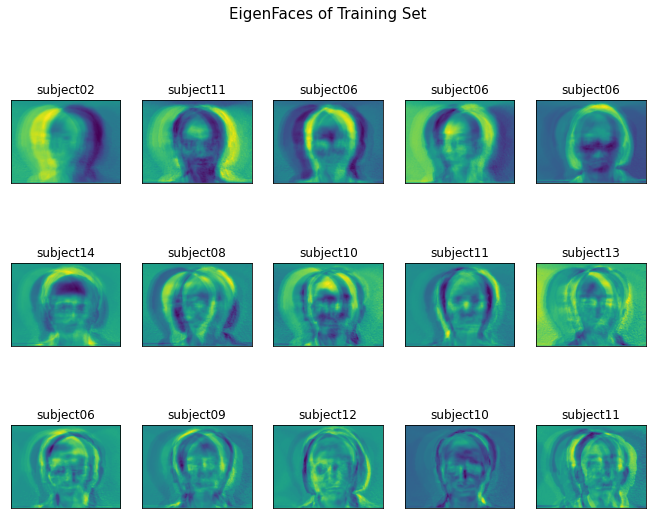

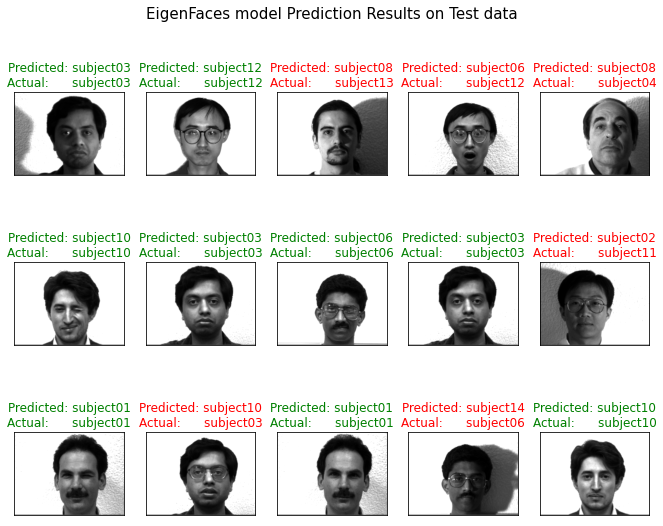

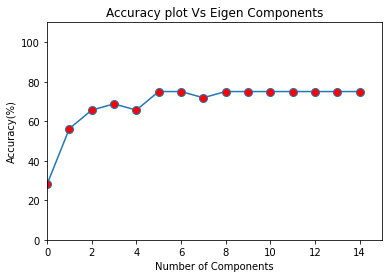

In [ ]:
# EigenFaces Evaluation
acc_metric_eigen = []
method = "Eigen"
print("Evaluating EigenFaces...")
for dimension in range(1,16):
    acc_metric_eigen.append(main(dimension,method))
    
plot_acc(acc_metric_eigen,method)

Evaluating FisherFaces...
Accuracy of the model for Fisher components 15:  96.88%

 Confusion Matrix: 
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

 Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00       

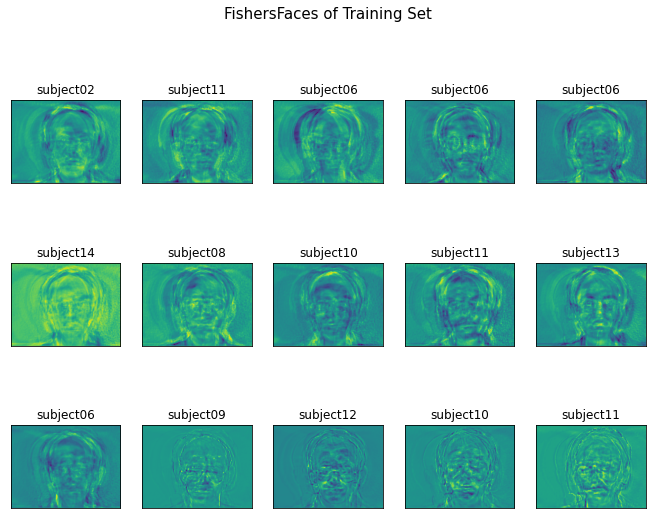

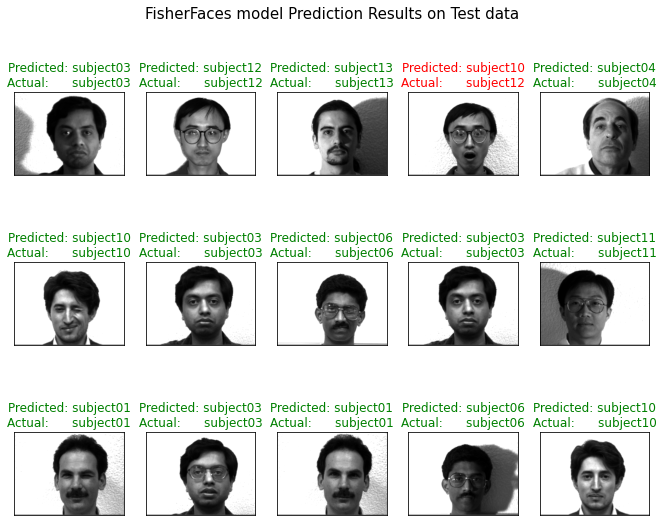

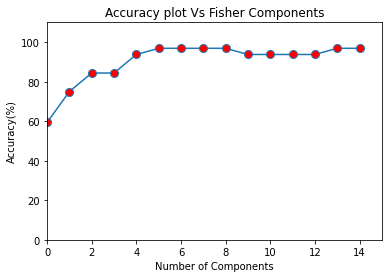

In [ ]:
# FisherFaces Evaluation
acc_metric_fisher = []
method = "Fisher"
print("Evaluating FisherFaces...")
for dimension in range(1,16):
    acc_metric_fisher.append(main(dimension,method))
    
plot_acc(acc_metric_fisher,method)

Evaluating EigenFaces w/o 3...
Accuracy of the model for Eigen w/o 3 components 15:  75.0%

 Confusion Matrix: 
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

 Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.80      1.00      0.89         4
           2       0.50      1.00      0.67         2
           3       0.67      1.00      0.80         2
           4       0.33      1.00      0.50         1
           5       1.00      1.00      1.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


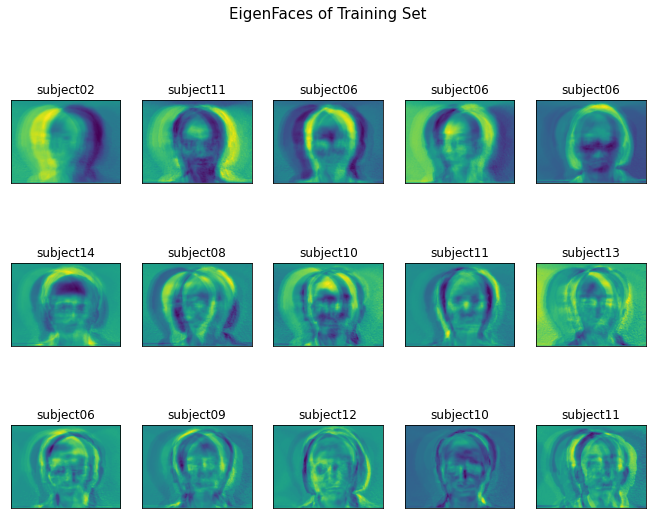

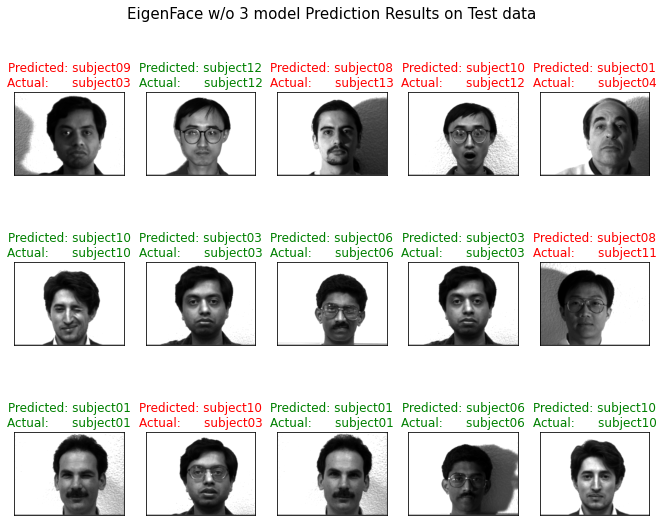

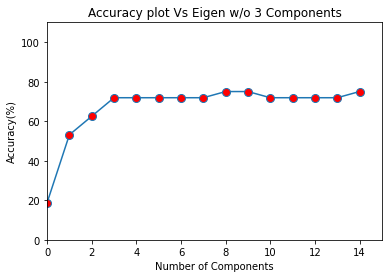

In [ ]:
# EigenFaces w/o 3 Evaluation
acc_metric_wo = []
method = "Eigen w/o 3"
print("Evaluating EigenFaces w/o 3...")
for dimension in range(1,16):
    acc_metric_wo.append(main(dimension,method))
    
plot_acc(acc_metric_wo,method)

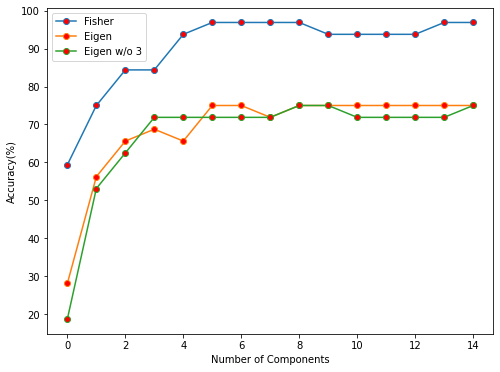

In [ ]:
plt.subplots(figsize =(8, 6))
plt.plot(acc_metric_fisher,marker='o', markerfacecolor='red', markersize=6)
plt.plot(acc_metric_eigen,marker='o', markerfacecolor='red', markersize=6)
plt.plot(acc_metric_wo,marker='o', markerfacecolor='red', markersize=6)
plt.legend(['Fisher','Eigen','Eigen w/o 3'])
plt.ylabel('Accuracy(%)') 
plt.xlabel('Number of Components')
plt.show()

Evaluating EigenFaces...
Accuracy of the model for Eigen components 15:  81.25%

 Confusion Matrix: 
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

 Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.80      1.00      0.89         4
           2       0.50      1.00      0.67         2
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         1
           5       0.67      1.00      0.80         

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


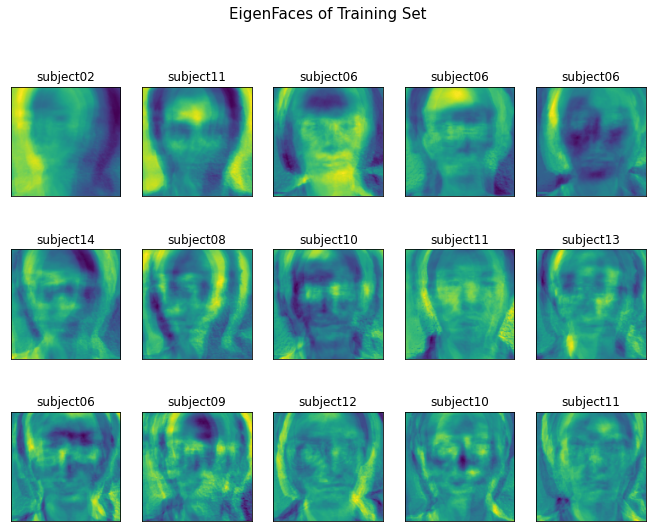

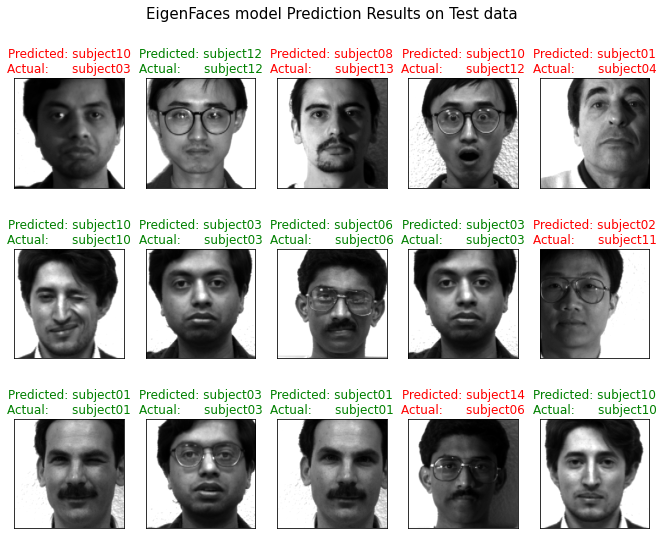

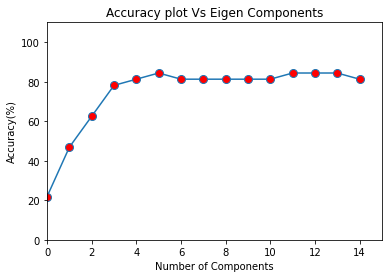

In [ ]:
# EigenFaces Evaluation
C_acc_metric_eigen = []
method = "Eigen"
print("Evaluating EigenFaces...")
for dimension in range(1,16):
    C_acc_metric_eigen.append(C_main(dimension,method))
    
plot_acc(C_acc_metric_eigen,method)

Evaluating FisherFaces...
Accuracy of the model for Fisher components 15:  96.88%

 Confusion Matrix: 
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

 Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00       

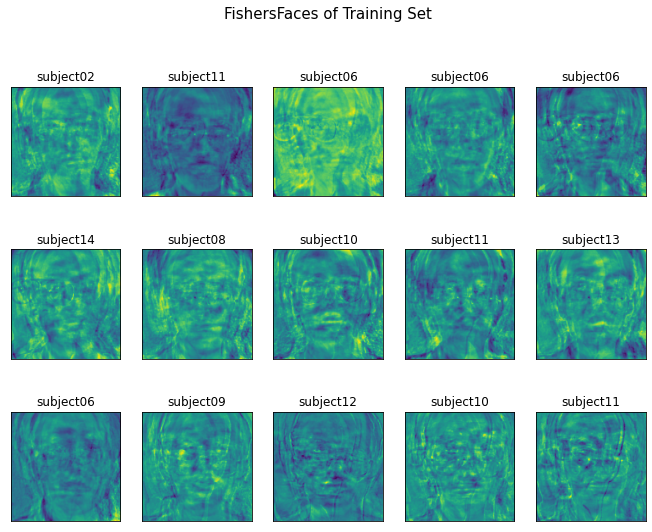

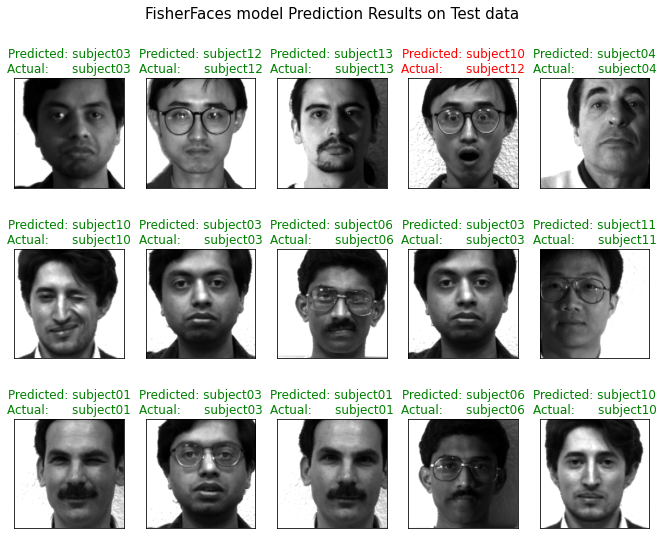

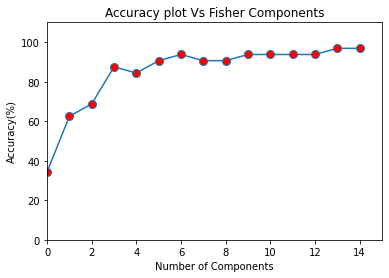

In [ ]:
# FisherFaces Evaluation
C_acc_metric_fisher = []
method = "Fisher"
print("Evaluating FisherFaces...")
for dimension in range(1,16):
    C_acc_metric_fisher.append(C_main(dimension,method))
    
plot_acc(C_acc_metric_fisher,method)

Evaluating EigenFaces w/o 3...
Accuracy of the model for Eigen w/o 3 components 15:  84.38%

 Confusion Matrix: 
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

 Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.80      1.00      0.89         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


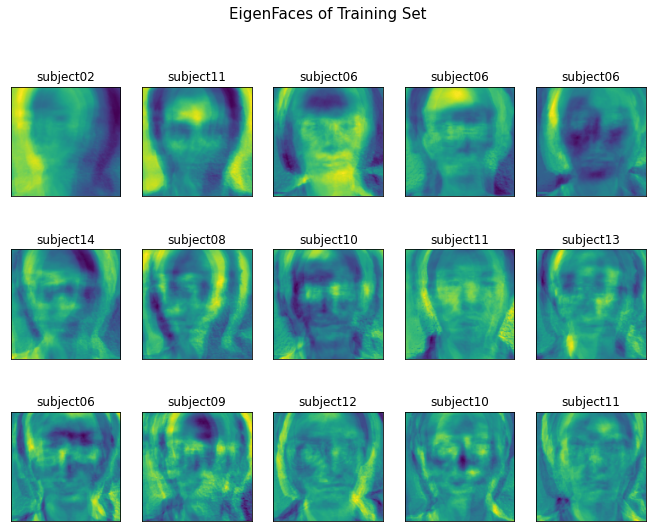

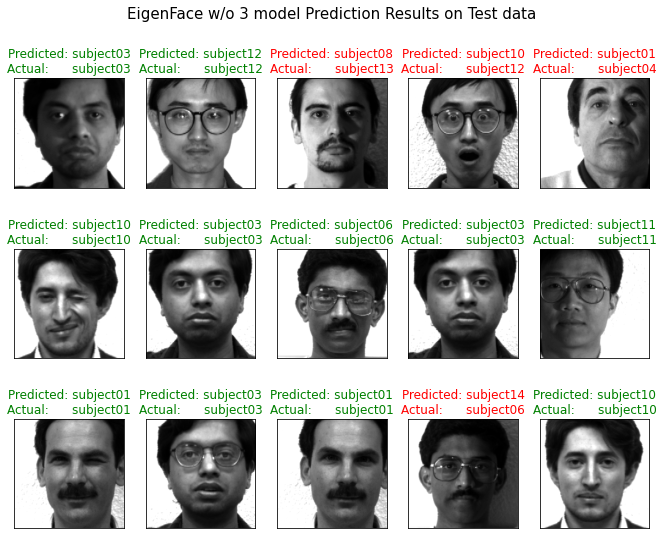

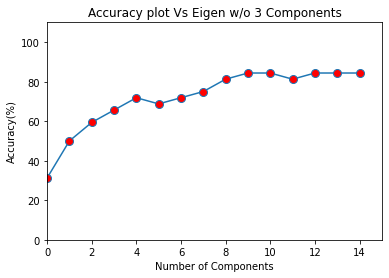

In [ ]:
C_acc_metric_wo = []
method = "Eigen w/o 3"
print("Evaluating EigenFaces w/o 3...")
for dimension in range(1,16):
    C_acc_metric_wo.append(C_main(dimension,method))    
plot_acc(C_acc_metric_wo,method)

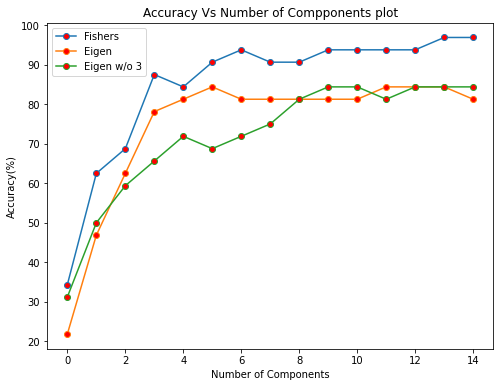

In [ ]:
plt.subplots(figsize =(8, 6)) 
plt.plot(C_acc_metric_fisher,marker='o', markerfacecolor='red', markersize=6)
plt.plot(C_acc_metric_eigen,marker='o', markerfacecolor='red', markersize=6)
plt.plot(C_acc_metric_wo,marker='o', markerfacecolor='red', markersize=6)
# plt.grid()
plt.title("Accuracy Vs Number of Compponents plot")
plt.legend(['Fishers','Eigen','Eigen w/o 3'])
plt.ylabel('Accuracy(%)') 
plt.xlabel(f'Number of Components')
plt.show()

In [ ]:
# print("Accuracy values for actual images")
# print("FisherFaces: ",acc_metric_fisher)
# print("EigenFaces : ",acc_metric_eigen)
# print("EigenFaces w/o 3: ",acc_metric_wo)
# print("Accuracy values for croped images")
# print("FisherFaces: ",C_acc_metric_fisher)
# print("EigenFaces : ",C_acc_metric_eigen)
# print("EigenFaces w/o 3: ",C_acc_metric_wo)

In [ ]:
print("Accuracy values for actual images")
print("FisherFaces: ",max(acc_metric_fisher))
print("EigenFaces : ",max(acc_metric_eigen))
print("EigenFaces w/o 3: ",max(acc_metric_wo))
print("Accuracy values for croped images")
print("FisherFaces: ",max(C_acc_metric_fisher))
print("EigenFaces : ",max(C_acc_metric_eigen))
print("EigenFaces w/o 3: ",max(C_acc_metric_wo))

Accuracy values for actual images
FisherFaces:  96.875
EigenFaces :  75.0
EigenFaces w/o 3:  75.0
Accuracy values for croped images
FisherFaces:  96.875
EigenFaces :  84.375
EigenFaces w/o 3:  84.375


In [ ]:
def error_rate(acc_array):
  error_arr = []
  for i in range(len(acc_array)):
    # if i%3 == 0:
      error_arr.append(100-acc_array[i])
  return error_arr

In [ ]:
error_rate_fisher = error_rate(acc_metric_fisher)
error_rate_eigen = error_rate(acc_metric_eigen)
error_rate_eigen3 = error_rate(acc_metric_wo)
C_error_rate_fisher = error_rate(C_acc_metric_fisher)
C_error_rate_eigen = error_rate(C_acc_metric_eigen)
C_error_rate_eigen3 = error_rate(C_acc_metric_wo)

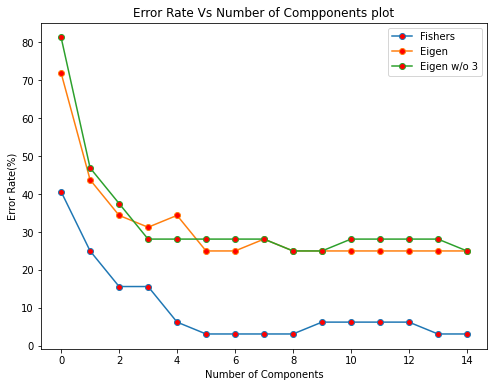

In [ ]:
plt.subplots(figsize =(8, 6)) 
plt.plot(error_rate_fisher,marker='o', markerfacecolor='red', markersize=6)
plt.plot(error_rate_eigen,marker='o', markerfacecolor='red', markersize=6)
plt.plot(error_rate_eigen3,marker='o', markerfacecolor='red', markersize=6)
# plt.grid()
plt.title("Error Rate Vs Number of Compponents plot")
plt.legend(['Fishers','Eigen','Eigen w/o 3'])
plt.ylabel('Error Rate(%)') 
plt.xlabel(f'Number of Components')
plt.show()

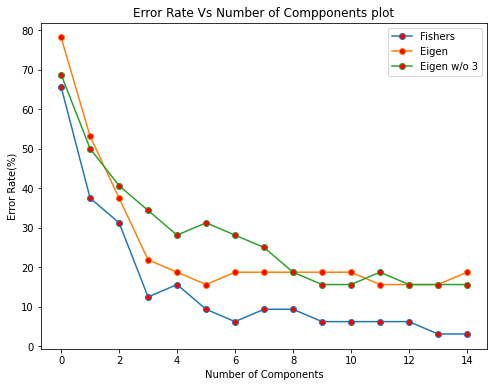

In [ ]:
plt.subplots(figsize =(8, 6)) 
plt.plot(C_error_rate_fisher,marker='o', markerfacecolor='red', markersize=6)
plt.plot(C_error_rate_eigen,marker='o', markerfacecolor='red', markersize=6)
plt.plot(C_error_rate_eigen3,marker='o', markerfacecolor='red', markersize=6)
# plt.grid()
plt.title("Error Rate Vs Number of Compponents plot")
plt.legend(['Fishers','Eigen','Eigen w/o 3'])
plt.ylabel('Error Rate(%)') 
plt.xlabel(f'Number of Components')
plt.show()

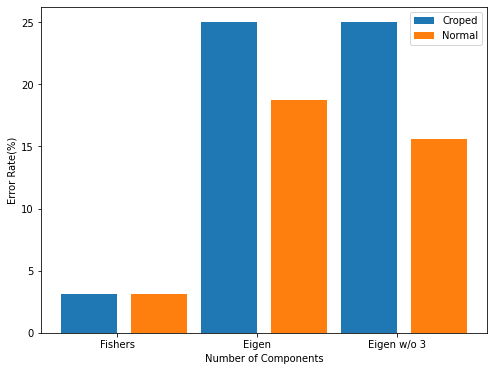

In [ ]:
idx = 14
model_errors = [error_rate_fisher[idx], error_rate_eigen[idx], error_rate_eigen3[idx]]
C_model_errors = [C_error_rate_fisher[idx], C_error_rate_eigen[idx], C_error_rate_eigen3[idx]]
plt.subplots(figsize =(8, 6)) 
barWidth = 0.4
l1 = list(range(1,6,2))
l2 = list(range(2,7,2))
plt.bar(l1,model_errors) 
plt.bar(l2,C_model_errors) 
plt.xticks([r + barWidth for r in range(1,6,2)],['Fishers','Eigen','Eigen w/o 3'])
plt.legend(["Croped","Normal"])
plt.ylim()
plt.ylabel('Error Rate(%)') 
plt.xlabel(f'Number of Components')
# plt.title()
plt.show()